# Reduced equations for linear bending waves

The name "reduced equations for linear bending waves" comes from Lubow+Ogilvie 2000; it refers A53-54 in Lubow+Ogilvie 2000 and B16-17 in Fairbairn 2025. This pair of coupled PDEs relates the tilt $\mathcal{W}$ and internal torque $\mathcal{G}$:

$$    \frac{\partial \mathcal{G}}{\partial t} = \frac{\Sigma H^2 \Omega^3 R^3}4 \frac{\partial \mathcal{W}}{\partial R}  - \alpha \Omega G  $$
$$ \Sigma \Omega R^2  \frac{\partial \mathcal{W}}{\partial t} = \frac{1}R \frac{\partial \mathcal{G}}{\partial R} $$

## Imports and normalizations

In [2]:
# %pip install fipy

import numpy as np
import time
import math
#import scipy.differentiate

import matplotlib.pyplot as plt

In [243]:
cs = 0.02
alpha = 0.001 # 0.001 # 0.019

## Numerical derivatives

In [4]:
def derivative(f, x):
    '''
    Returns first derivative of f(x) with respect to the domain x.

    '''
    
    # return scipy.differentiate.derivative(f, x)

    derivs = np.zeros(shape=f.shape)

    # handle boundaries
    derivs[0] = (f[1] - f[0]) / (x[1] - x[0])
    derivs[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])

    # central difference method
    for i in range(1, len(x)-1):
        derivs[i] = (f[i+1] - f[i-1]) / (x[i+1] - x[i-1])

    return derivs

## Disk information

Normalizations:
- $R_0 = 1$
- $\Omega_{K,0} = 1$
- $c_s = 0.02$
- $\alpha = 0.019$
- Density profile: $K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2$

### Density profile

In [5]:
def Sigma(Rs):
    '''
    Returns the disk's background surface density profile.
    
    '''
    
    K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2
    fgaps = f_gap(Rs, K, R_a, R_b, D_a, D_b)
    
    Sigma0 = 1
    
    return Sigma0 * Rs**(-3/2) / fgaps

def f_gap(Rs, K, R_a, R_b, D_a, D_b):
    '''
    Function that "shapes" the disk gap profile. Used in `sigma` function. 
    R_a and R_b are the locations of the inner and outer gap edges,
    D_a and D_b are the steepness of the edges, and K determines the
    depth of the gap.
    
    '''

    return 1 + (K-1)/2 * \
        (np.tanh((Rs - R_a)/D_a) - np.tanh((Rs - R_b)/D_b))

In [6]:
## check shape of disk profile
# K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2
# plt.plot(Rs, sigma(Rs))

### Angular frequency and scale height

In [7]:
def OmegaK(Rs):
    '''
    Returns the Keplerian angular velocity profile.

    '''
    OmegaK_0 = 1 # Omega_K at R=R_0
    return OmegaK_0 * Rs**(-3/2)

def scaleHeight(Rs):
    '''
    Returns the disk's scale height profile. We use H = c_sound / Omega_K.

    '''
    return cs / OmegaK(Rs)    

def Omega(Rs):
    '''
    Returns the disk's background angular velocity profile.

    '''

    OmegaKs = OmegaK(Rs)
    rho_mids = Sigma(Rs) / (np.sqrt(2*np.pi) * scaleHeight(Rs))
    
    coeff = np.sqrt(1 + (cs / (Rs*OmegaKs))**2 * derivative(np.log(rho_mids), np.log(Rs)))
    
    return OmegaKs * coeff

## Integration functions

Boundary conditions:
- $\mathcal{W}(R_\text{min}, 0) = 0$
- $\mathcal{W}(R_\text{max}, 0) = 0.1$ (it just needs to be a constant)

In [121]:
def dG_dt(Rs_torque, Gs, Rs_warp, Ws):
    '''
    Returns dG/dt over the R domain (Rs_torque) for Gs.
    
    Assumes that `Ws` and `Gs` are staggered in the R domain:
    Ws should be indexed from 0 through N, while `Gs` should be indexed
    from 1/2 to N-1/2.

    '''

    # since we're changing G, compute values over G's R domain
    Sigmas = Sigma(Rs_torque) # length N
    Hs = scaleHeight(Rs_torque)
    Omegas = Omega(Rs_torque)
    
    dW_dRs = (Ws[1:] - Ws[:-1]) / (Rs_warp[1:] - Rs_warp[:-1]) # length N

    term1 = Sigmas * (Hs**2) * (Omegas**3) * (Rs_torque**3) / 4 * dW_dRs # sloshing term
    term2 = (-1) * alpha * Omegas * Gs # viscous term
    
    return term1 + term2

def dW_dt(Rs_torque, Gs, Rs_warp, Ws):
    '''
    Returns dW/dt over the R domain (Rs) for Ws.
    
    Assumes that `Ws` and `Gs` are staggered in the R domain:
    Ws should be indexed from 0 through N, while `Gs` should be indexed
    from 1/2 to N-1/2.

    '''

    # since we're changing W, compute values over W's R domain
    Sigmas = Sigma(Rs_warp) # length N+1
    Omegas = Omega(Rs_warp)
    
    # set dG_dR = 0 at boundaries so that W is constant at boundaries
    dG_dRs_middle = (Gs[1:] - Gs[:-1]) / (Rs_torque[1:] - Rs_torque[:-1]) # length N-1
    dG_dRs = np.zeros(shape=Rs_warp.shape)
    dG_dRs[1:-1] = dG_dRs_middle

    coeff = (Sigmas * Omegas * Rs_warp**3)**(-1)
    return coeff * dG_dRs 

In [217]:
def evolve_G(Rs_torque, Gs, Rs_warp, Ws, dt):
    '''
    Use the predictor-corrector method to evolve G(R) forward by one timestep (dt).
    W and G are staggered in the R domain.

    '''

    # predictor step
    F1 = dG_dt(Rs_torque, Gs, Rs_warp, Ws)
    Gprimes = Gs + F1*dt

    # corrector step
    F2 = dG_dt(Rs_torque, Gprimes, Rs_warp, Ws)
    Gnexts = Gs + (F1+F2)/2 * dt

    return Gnexts

def evolve_W(Rs_torque, Gs, Rs_warp, Ws, dt):
    '''
    Use the predictor-corrector method to evolve W(R) forward by one timestep (dt).
    W and G are staggered in the R domain.
    
    '''

    # predictor step
    F1 = dW_dt(Rs_torque, Gs, Rs_warp, Ws)
    Wprimes = Ws + F1*dt

    # corrector step
    F2 = dW_dt(Rs_torque, Gs, Rs_warp, Wprimes)
    Wnexts = Ws + (F1+F2)/2 * dt
    
    # fix the boundaries at constant warps (handled in dW_dt)
#     Wnexts[0] = Ws[0]
#     Wnexts[-1] = Ws[-1]

    return Wnexts

In [218]:
def integrate(Rs_torque, Gs, Rs_warp, Ws, ts):
    '''

    Integrate W(R) and G(R) over a given time domain (ts). Returns W(R) and 
    G(R) at the final timestep.
    
    W and G are staggered in the R domain.

    '''

    dts = ts[1:] - ts[:-1]
    
    for dt in dts:
        Gnexts = evolve_G(Rs_torque, Gs, Rs_warp, Ws, dt)
        Wnexts = evolve_W(Rs_torque, Gs, Rs_warp, Ws, dt)

        Ws, Gs = Wnexts, Gnexts

    return Ws, Gs

## Run a sim

Note that, from the $\frac{\partial \mathcal{G}}{\partial t} = \frac{\Sigma H^2 \Omega^3 R^3}4 \frac{\partial \mathcal{W}}{\partial R}  - \alpha \Omega G$, we can see that $t \sim \Omega^{-1} h^{-1}$ and $t \sim \Omega^{-1} \alpha^{-1} $ are both relevant timescales. This corresponds to $\sim$10-100 $\Omega^{-1}$.

In [262]:
# spatial and time domains
Rmin = 0.5
Rmax = 3.5
DeltaR = 0.1
num_Rs = (int) ((Rmax - Rmin) / DeltaR) + 1

# stagger W and G in the R domain
Rs_warp = np.linspace(Rmin, Rmax, num_Rs)
Rs_torque = Rs_warp[:-1] + DeltaR/2

tmin = 0
tmax = 6000
Deltat = 0.05
num_ts = (int) ((tmax - tmin) / Deltat) + 1
ts = np.linspace(tmin, tmax, num_ts)

Ws = 0.1 * np.cumsum(np.exp(-(Rs_warp-2)**2 / 2) / np.sqrt(2*np.pi)) * DeltaR

#Ws = np.zeros(shape=Rs.shape) + (Rs-0.5)/30 # tilt W(R)
Gs = np.zeros(shape=Rs_torque.shape) # torque G(R)

Elapsed time: 24.71


<ipython-input-121-2b402feb65a6>:42: RuntimeWarning: invalid value encountered in reciprocal
  coeff = (Sigmas * Omegas * Rs_warp**3)**(-1)


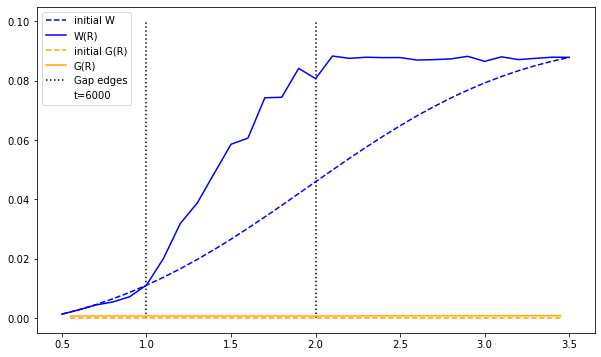

In [263]:
fig = plt.figure(figsize=(10, 6))

start = time.time()

Ws_final, Gs_final = integrate(Rs_torque, Gs, Rs_warp, Ws, ts)
# Ws_final, Gs_final = integrate(Rs_torque, Gs_final, Rs_warp, Ws_final, ts)


end = time.time()
print("Elapsed time:", np.round(end - start, 2))

plt.plot(Rs_warp, Ws, c="blue", ls="--", label="initial W")
plt.plot(Rs_warp, Ws_final, c="blue", label="W(R)")
plt.plot(Rs_torque, Gs, c="orange", ls="--", label="initial G(R)")
plt.plot(Rs_torque, Gs_final, c="orange", label="G(R)")

R_a, R_b = 1, 2
plt.vlines(R_a, 0, 0.1, color="black", linestyle=":")
plt.vlines(R_b, 0, 0.1, color="black", linestyle=":", label="Gap edges")

plt.scatter([],[], s=0, label="t=" + str(tmax))

plt.legend()
plt.show()

In [264]:
Gs_final[:10]

array([0.00068452, 0.00068098, 0.00068069, 0.00068454, 0.00067457,
       0.00067618, 0.00067601, 0.00067592, 0.00067482, 0.00067583])

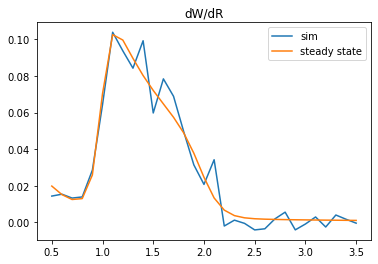

In [265]:
def A(Rs):
    
    return Sigma(Rs) * scaleHeight(Rs)**2 * Omega(Rs)**3 * Rs**3 / 4

plt.plot(Rs_warp, np.gradient(Ws_final, Rs_warp), label="sim")
plt.plot(Rs_warp, alpha * Omega(Rs_warp) * 7e-4 / A(Rs_warp), label="steady state")
# note: 7e-6 is our arbitrary value for the constant G; it comes from the outer boundary conditions
# on W

plt.title("dW/dR")
plt.legend()